### 边缘框
> * 一个边缘框可以通过4个数字定义：（这里的y轴是从上往下的，x轴正常，具体如下图）
>> * （左上x，左上y，右下x，右下y）
>> * （左上x，左上y，宽，高）

![](../images/bounding-box.png)

### 目标检测数据集
> * 每行表示一个物体
>> * 图片文件名， 物体类别， 边缘框
> * COCO([cocodataset.org](https://cocodataset.org/#home))
>> * 80物体，330k图片，1.5M物体

### 总结
> * 物体检测识别图片里的多个物体的类别和位置
> * 位置通常用边缘框表示

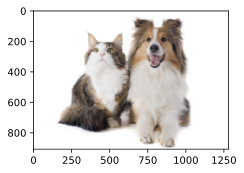

In [1]:
%matplotlib inline
import torch
from d2l import limutorch as d2l

d2l.set_figsize()
img = d2l.plt.imread('../images/catdog.png')
d2l.plt.imshow(img)

In [2]:
"""定义两种边缘框之间转换的函数"""
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间， 高度， 宽度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    #print(cx.shape)
    cy = (y1 + y2) / 2
    w = (x2 - x1)
    h = (y2 - y1)
    boxes = torch.stack((cx, cy, w, h), axis = -1)
    return boxes

def box_center_corner(boxes):
    """从（中间， 高度， 宽度）转换到（左上， 右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    #print(x1.shape)
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis = -1)
    return boxes

In [3]:
cat_bbox, dog_bbox = [200, 150, 640, 770],  [660, 50, 1050, 890]
boxes = torch.tensor((cat_bbox, dog_bbox))
#print(boxes.shape)
#print(box_corner_to_center(boxes).shape)
box_center_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

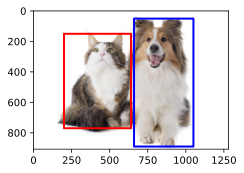

In [4]:
"""将边界框在图中画出"""
def bbox_to_rect(bbox, color):
    """将边界框（左上X， 左上Y，右上X， 右下Y）转换为matplotlib格式：（左上X，左上Y， 宽， 高）"""
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]),
                             width = bbox[2] - bbox[0],
                             height = bbox[3] - bbox[1],
                             fill=False, edgecolor=color, linewidth=2)

fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

In [6]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import limutorch as d2l

d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip',
                                    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [7]:
"""读取香蕉检测数据集"""
def read_data_bananas(is_train=True):
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():##iterrows()是遍历所有元素
        images.append(torchvision.io.read_image(
            os.path.join(data_dir,
                         'bananas_train' if is_train else 'bananas_val',
                         'images', f'{img_name}')))
        targets.append((list(target)))
    return images, torch.tensor(targets).unsqueeze(1) / 256 ### unsqueeze用于添加一个维度

In [8]:
"""创建一个自定义Dataset实例"""
class BananaDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) +
              (f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [9]:
"""为训练集和测试集返回两个数据加载器实例"""
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananaDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananaDataset(is_train=False),batch_size)
    return train_iter, val_iter

In [10]:
"""读取一个小批量，打印其中的图像和标签的形状"""
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape, train_iter

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]),
 torch.Size([32, 1, 5]),
 <torch.utils.data.dataloader.DataLoader at 0x2d9cf518100>)

torch.Size([10, 256, 256, 3])


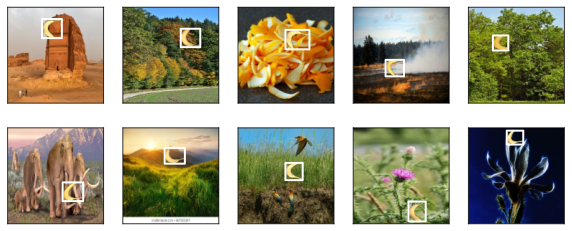

In [52]:
"""演示"""
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255 ## permute()实现将维度换位
print(imgs.shape)
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors='w')